# Credit Card Transaction Fraud Detection

In [1]:
# Preprocessing
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

#Oversampling and Undersampling
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

#Model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#Figures
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

#For reproducability
RANDOM_STATE = 1

Loading the data.

In [2]:
data = pd.read_csv(r"./data/fraudTrain.csv")

data.drop(data.columns[0], axis=1, inplace=True)

## Imbalanced Data

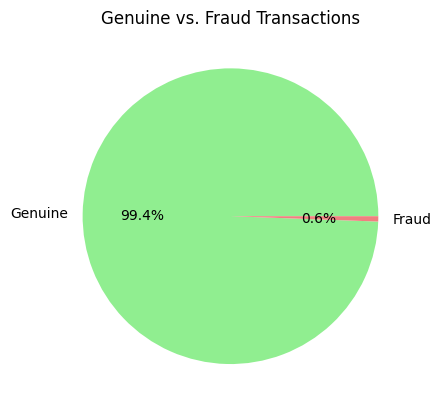

In [3]:
labels = ["Genuine", "Fraud"]

is_fraud_train = data["is_fraud"].value_counts()

plt.pie(is_fraud_train,labels=labels, colors=["lightgreen", "lightcoral"], autopct='%1.1f%%')
plt.title("Genuine vs. Fraud Transactions")
plt.show()

Since 99.4% of the data are genuine transactions, if we do a blind guess of genuine transactions, we will have an accuracy of 99.4%.

## Preprocessing Data

Renaming the columns to be more intuitive.

In [4]:
data.rename(columns={"cc_num": "credit_card",
                     "trans_num": "trans_id"},
                inplace=True)

print("Training Data:")
data.head(5)

Training Data:


,trans_date_trans_time,credit_card,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_id,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


Splitting the data into features and target.

In [5]:
# TODO change data to normal distribution
# TODO make sure no leaks with data over time

# Turning the transaction time to be numerical and based on time only.
data["time"] = pd.to_datetime(data["unix_time"], unit="s")
data["time"] = data["time"].dt.hour

features = ['credit_card', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'merch_lat', 'merch_long', 'time']
categorical_features = ['credit_card', 'merchant', 'category', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'job', 'dob']
target = "is_fraud"

# Using ordinal encodings to encode categorical features for data.
ord_enc = OrdinalEncoder(dtype=np.float64)

df_features = data[features]
df_features.loc[:, categorical_features] = ord_enc.fit_transform(df_features[categorical_features])

X = df_features.astype("float64")
Y = data[target]

# Split the data into training and testing. Stratify the data to ensure the split is representative of the actual data.
X_train_all, X_test_all, Y_train_all, Y_test_all = train_test_split(X, Y, stratify=Y, train_size=0.8, random_state=RANDOM_STATE)

X.head(5)

,credit_card,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,merch_lat,merch_long,time
0,444.0,514.0,8.0,4.97,162.0,18.0,0.0,568.0,526.0,27.0,265.0,36.0788,-81.1781,3495.0,370.0,779.0,36.011293,-82.048315,0.0
1,42.0,241.0,4.0,107.23,309.0,157.0,0.0,435.0,612.0,47.0,965.0,48.8878,-118.2105,149.0,428.0,607.0,49.159047,-118.186462,0.0
2,237.0,390.0,0.0,220.11,115.0,381.0,1.0,602.0,468.0,13.0,858.0,42.1808,-112.2620,4154.0,307.0,302.0,43.150704,-112.154481,0.0
3,509.0,360.0,2.0,45.00,163.0,463.0,1.0,930.0,84.0,26.0,614.0,46.2306,-112.1138,1939.0,328.0,397.0,47.034331,-112.561071,0.0
4,368.0,297.0,9.0,41.96,336.0,149.0,1.0,418.0,216.0,45.0,231.0,38.4207,-79.4629,99.0,116.0,734.0,38.674999,-78.632459,0.0


## Feature Importance

To determine which features to select, fit a model to the data.

In [6]:
model_rf = RandomForestClassifier(random_state=RANDOM_STATE)
model_rf.fit(X_train_all, Y_train_all)

RandomForestClassifier(random_state=1)

Using the mean decrease in impurity (MDI), plot the feature importance to determine the most important features.

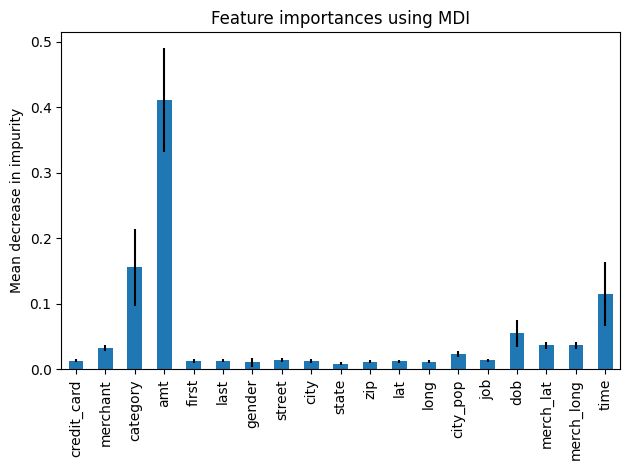

In [7]:
mdi_importances = model_rf.feature_importances_
mdi_std = np.std([tree.feature_importances_ for tree in model_rf.estimators_], axis=0)

mdi_importances = pd.Series(mdi_importances, index=features)

mdi_fig, mdi_ax = plt.subplots()
mdi_importances.plot.bar(yerr=mdi_std, ax=mdi_ax)
mdi_ax.set_title("Feature importances using MDI")
mdi_ax.set_ylabel("Mean decrease in impurity")
mdi_fig.tight_layout()

Using feature permutation, plot the feature importance to determine the most important features.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


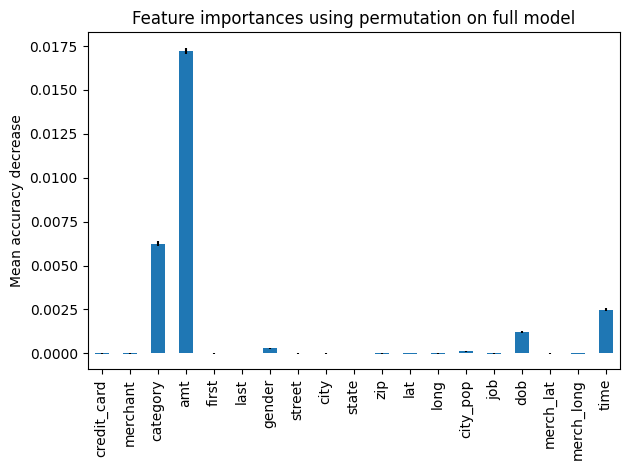

In [8]:
perm_res = permutation_importance(
    model_rf, X_test_all, Y_test_all, n_repeats=10, random_state=RANDOM_STATE, n_jobs=4
)

perm_importances = pd.Series(perm_res.importances_mean, index=features)

perm_fig, perm_ax = plt.subplots()
perm_importances.plot.bar(yerr=perm_res.importances_std, ax=perm_ax)
perm_ax.set_title("Feature importances using permutation on full model")
perm_ax.set_ylabel("Mean accuracy decrease")
perm_fig.tight_layout()
plt.show()

The features `["merchant", "category", "amt", "city_pop", "job", "dob", "merch_lat", "merch_long", "time"]` were found to be the most important.

In [9]:
selected_features = ["merchant", "category", "amt", "city_pop", "job", "dob", "merch_lat", "merch_long", "time"]

X_selected = X[selected_features]

X_train, X_test, Y_train, Y_test = train_test_split(X_selected, Y, stratify=Y, train_size=0.8, random_state=RANDOM_STATE)

## Baseline Performance
First, we take a look at a baseline performance using Logistic Regression

In [10]:
scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train)
X_test_scaled = scalar.transform(X_test)

model_logreg = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
model_logreg.fit(X_train_scaled, Y_train)

Y_pred_model_logreg = model_logreg.predict(X_test_scaled)

Classification Report: 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    257834
           1       0.00      0.00      0.00      1501

    accuracy                           0.99    259335
   macro avg       0.50      0.50      0.50    259335
weighted avg       0.99      0.99      0.99    259335



Metrics train:
	Accuracy score: 0.9937
Metrics test:
	Accuracy score: 0.9937


Confusion Matrix:


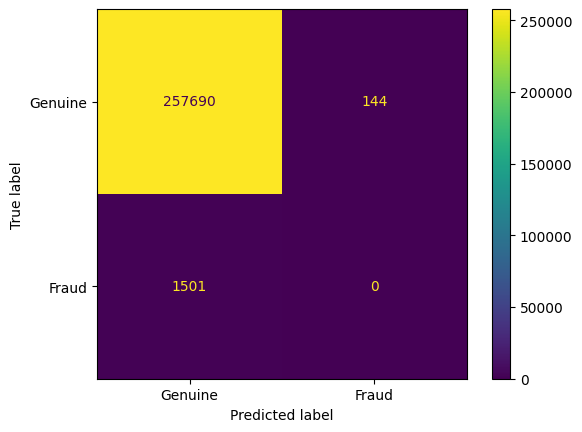

In [18]:
print(f"Classification Report: \n{classification_report(Y_test, Y_pred_model_logreg)}\n\n")

print(
    f"Metrics train:\n\tAccuracy score: {accuracy_score(model_logreg.predict(X_train_scaled),Y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(model_logreg.predict(X_test_scaled),Y_test):.4f}\n\n")

print("Confusion Matrix:")
cm_display_model = ConfusionMatrixDisplay(confusion_matrix(Y_test, Y_pred_model_logreg), display_labels=["Genuine", "Fraud"])
cm_display_model.plot()

Then, we take a look at the baseline performance of Random Forest

In [22]:
model_rf.fit(X_train, Y_train)

Y_pred_model_rf = model_rf.predict(X_test)

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.96      0.67      0.79      1501

    accuracy                           1.00    259335
   macro avg       0.98      0.83      0.89    259335
weighted avg       1.00      1.00      1.00    259335



Metrics train:
	Accuracy score: 0.9981
Metrics test:
	Accuracy score: 0.9979


Confusion Matrix:


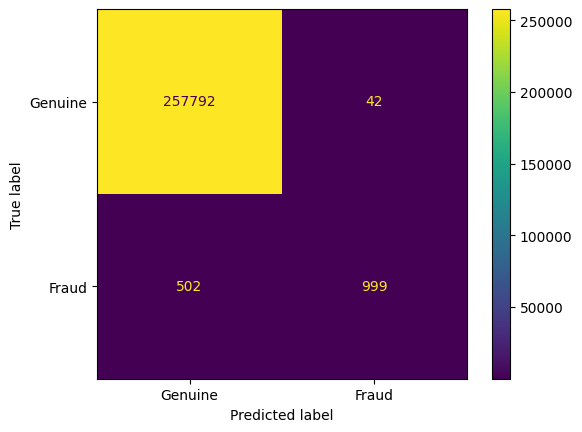

In [23]:
print(f"Classification Report: \n{classification_report(Y_test, Y_pred_model_rf)}\n\n")

print(
    f"Metrics train:\n\tAccuracy score: {accuracy_score(model_rf.predict(X_train),Y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(model_rf.predict(X_test),Y_test):.4f}\n\n")

print("Confusion Matrix:")
cm_display_model = ConfusionMatrixDisplay(confusion_matrix(Y_test, Y_pred_model_rf), display_labels=["Genuine", "Fraud"])
cm_display_model.plot()

## SMOTE + Tomek Links
Because the data is imbalanced, we combine SMOTE and Tomek Links to resample the data.

In [ ]:
tomek = TomekLinks(sampling_strategy="majority")
smotetomek = SMOTETomek(tomek=tomek, random_state=RANDOM_STATE)

X_train_smotetomek, Y_train_smotetomek = smotetomek.fit_resample(X_train, Y_train)

# Plot the data after resampling
is_fraud_train_smotetomek = Y_train_smotetomek.value_counts()

plt.pie(is_fraud_train_smotetomek,labels=labels, colors=["lightgreen", "lightcoral"], autopct='%1.1f%%')
plt.title("Genuine vs. Fraud Transactions After SMOTE + Tomek")
plt.show()

Running the line of code below will cause the rest of the notebook to use the SMOTE + Tomek data.

In [ ]:
X_train, Y_train = X_train_smotetomek, Y_train_smotetomek

## Model: Decision Tree
Finding and tuning hyperparameters of the Decision Tree using GridSearch.

In [ ]:
max_depths = [1, 2, 5, 10, None] # Determines how far down a decision tree goes before stopping
min_splits = [2, 5, 10, 50] # Determines the minimum sample split size before stopping
param_grid_dt = {"max_depth": max_depths,
                            "min_samples_split": min_splits,}

grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=RANDOM_STATE), 
                                  param_grid_dt, 
                                  verbose=3, n_jobs=4)
grid_dt.fit(X_train, Y_train)

print(f"Decision Tree Params: {grid_dt.best_params_}")

```{note}
This may take a while, so not running GridSearch and using the default values given should work.
```

Fitting the data to the Decision Tree with the hyperparameters found.

In [12]:
try:
    max_depth_dt = grid_dt.best_params_["max_depth"]
    min_samples_split_dt = grid_dt.best_params_["min_samples_split"]
except (NameError, AttributeError):
    max_depth_dt = 10
    min_samples_split_dt = 50

model_dt = DecisionTreeClassifier(
                            min_samples_split=min_samples_split_dt,
                            max_depth=max_depth_dt,
                            random_state=RANDOM_STATE)
model_dt.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=10, min_samples_split=50, random_state=1)

Analysis using a classification report, confusion matrix and accuracy.

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.94      0.78      0.86      1501

    accuracy                           1.00    259335
   macro avg       0.97      0.89      0.93    259335
weighted avg       1.00      1.00      1.00    259335


Metrics train:
	Accuracy score: 0.9986
Metrics test:
	Accuracy score: 0.9985


Confusion Matrix:


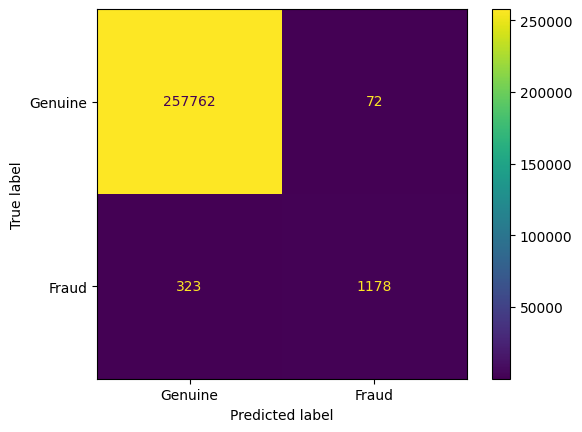

In [19]:
Y_pred_dt = model_dt.predict(X_test)

print(f"Classification Report: \n{classification_report(Y_test, Y_pred_dt)}\n")

print(
    f"Metrics train:\n\tAccuracy score: {accuracy_score(model_dt.predict(X_train),Y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(model_dt.predict(X_test),Y_test):.4f}\n\n")

print("Confusion Matrix:")
cm_display_dt = ConfusionMatrixDisplay(confusion_matrix(Y_test, Y_pred_dt), display_labels=["Genuine", "Fraud"])
cm_display_dt.plot()

## Model: Random Forest
Becasue Decision Trees are sensitive to changes in data, we use the tree ensemble method Random Forest to mitigate the effects of changes in data.

Finding and tuning hyperparameters of the Random Forest using GridSearch.

In [ ]:
max_depths = [2, 5, 10, None] # Determines how far down a decision tree goes before stopping
min_splits = [2, 5, 10, 50] # Determines the minimum sample split size before 
n_estimators = [50, 100, 150, 200] # Determines the number of trees used per forest
param_grid_rf = {"max_depth": max_depths,
                            "min_samples_split": min_splits,
                            "n_estimators": n_estimators}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE), 
                                  param_grid_rf, 
                                  verbose=3, n_jobs=4)
grid_rf.fit(X_train, Y_train)

print(f"Random Forest Params: {grid_rf.best_params_}")

```{note}
This will take a while, so not running GridSearch and using the default values given should work.
With the default hyperparameters, it should take 4-12 minutes.
```

Fitting the data to the Random Forest with the hyperparameters found.

In [14]:
try:
    max_depth_rf = grid_rf.best_params_["max_depth"]
    min_samples_split_rf = grid_rf.best_params_["min_samples_split"]
    n_estimators_rf = grid_rf.best_params_["n_estimators"]
except (NameError, AttributeError):
    max_depth_rf = 10
    min_samples_split_rf = 2
    n_estimators_rf = 150

model_rf = RandomForestClassifier(
                            min_samples_split=min_samples_split_rf,
                            max_depth=max_depth_rf,
                            n_estimators=n_estimators_rf,
                            random_state=RANDOM_STATE)
model_rf.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, n_estimators=150, random_state=1)

Analysis using a classification report, confusion matrix and accuracy.

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.96      0.67      0.79      1501

    accuracy                           1.00    259335
   macro avg       0.98      0.83      0.89    259335
weighted avg       1.00      1.00      1.00    259335


Metrics train:
	Accuracy score: 0.9981
Metrics test:
	Accuracy score: 0.9979


Confusion Matrix:


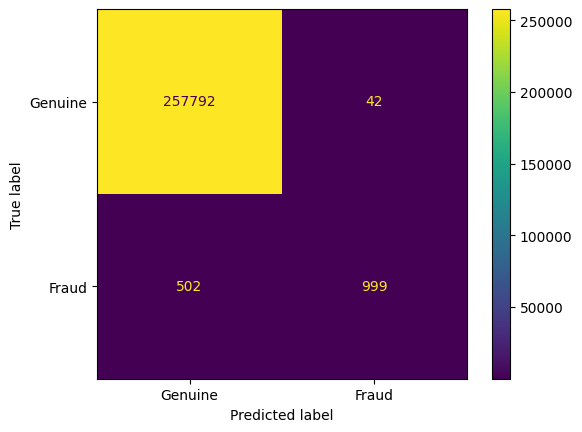

In [20]:
Y_pred_rf = model_rf.predict(X_test)

print(f"Classification Report: \n{classification_report(Y_test, Y_pred_rf)}\n")

print(
    f"Metrics train:\n\tAccuracy score: {accuracy_score(model_rf.predict(X_train),Y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(model_rf.predict(X_test),Y_test):.4f}\n\n")

print("Confusion Matrix:")
cm_display_rf = ConfusionMatrixDisplay(confusion_matrix(Y_test, Y_pred_rf), display_labels=["Genuine", "Fraud"])
cm_display_rf.plot()

### Model: XGBoostClassifier
In order to speedup the algorithm, we use XGBoost.

Finding and tuning hyperparameters of the XGBClassifier using GridSearch.

In [ ]:
max_depths = [3, 5, 7, 10] # Determines how far down a decision tree goes before stopping
gamma = [0.1, 0.3, 0.5, 0.9] # Determines minimum loss reduction for a split
min_child_weight = [1, 3, 5, 7] #  Determines minimum weight needed for a child
param_grid_xgb = {"max_depth": max_depths,
                  "gamma": gamma,
                  "min_child_weight": min_child_weight}

grid_xgb = GridSearchCV(XGBClassifier(random_state=RANDOM_STATE), 
                                  param_grid_xgb, 
                                  verbose=3, n_jobs=4)
grid_xgb.fit(X_train, Y_train)

print(f"Random Forest Params: {grid_xgb.best_params_}")

```{note}
This may take a while, so not running GridSearch and using the default values given should work.
```

Fitting the data to the XGBClassifier with the hyperparameters found.

In [16]:
try:
    max_depth_xgb = grid_xgb.best_params_["max_depth"]
    gamma_xgb = grid_xgb.best_params_["gamma"]
    min_child_weight_xgb = grid_xgb.best_params_["min_child_weight"]
except (NameError, AttributeError):
    max_depth_xgb = 7
    gamma_xgb = 0.1
    min_child_weight_xgb = 5

model_xgb = XGBClassifier(
                            max_depth=max_depth_xgb,
                            gamma=gamma_xgb,
                            min_child_weight=min_child_weight_xgb,
                            random_state=RANDOM_STATE)

model_xgb.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.94      0.81      0.87      1501

    accuracy                           1.00    259335
   macro avg       0.97      0.90      0.93    259335
weighted avg       1.00      1.00      1.00    259335


Metrics train:
	Accuracy score: 0.9991
Metrics test:
	Accuracy score: 0.9986


Confusion Matrix:


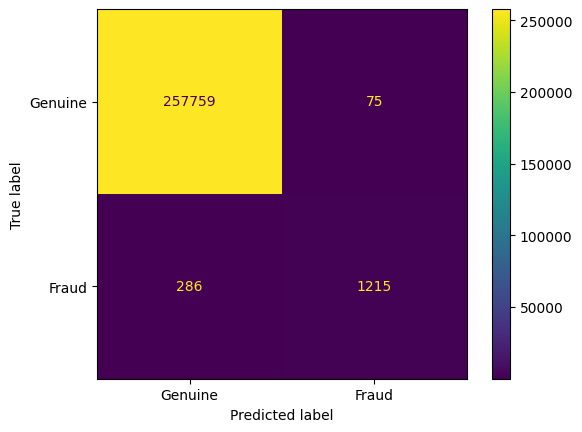

In [21]:
Y_pred_xgb = model_xgb.predict(X_test)

print(f"Classification Report: \n{classification_report(Y_test, Y_pred_xgb)}\n")

print(
    f"Metrics train:\n\tAccuracy score: {accuracy_score(model_xgb.predict(X_train),Y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(model_xgb.predict(X_test),Y_test):.4f}\n\n")

print("Confusion Matrix:")
cm_display_xgb = ConfusionMatrixDisplay(confusion_matrix(Y_test, Y_pred_xgb), display_labels=["Genuine", "Fraud"])
cm_display_xgb.plot()